# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals prior to time-frequency-based analyses. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. Temporal filtering  
High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 

2. Create epochs  
Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 

3. Outlier data rejection  
3.1. Preliminar rejection  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.
3.2. ICA decomposition  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.
3.3. Autoreject  
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.
4. Outlier channel interpolation  
The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 
5. Set average reference (optional)
Additionally, the EEG reference can be changed to a “virtual reference” that 
is the average of all channels using mne-Python.


## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [4]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.epochs import create_epochs
from eeg_preprocessing.utils.raw import read_raw_measurement

%matplotlib qt

## Load raw data


See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  

In [5]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser()

display(fc)

FileChooser(path='/Users/weian/crnl/eeg-preprocessing/tutorials', filename='', title='HTML(value='', layout=La…

In [6]:
# Load selected file
base_path = Path(fc.selected).parent

# Load selected file
raw = read_raw_measurement(raw_file_path=fc.selected, add_info=True)
print(raw.info)

Extracting parameters from /Volumes/crnl-memo-hd/EEG 2/82_L_Day2.vhdr...
Setting channel info structure...
<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 fid: 82_L_Day2
 highpass: 0.0 Hz
 is_annotated: True
 lowpass: 1000.0 Hz
 meas_date: 2021-05-11 14:06:18 UTC
 nchan: 64
 num_day: 2
 projs: []
 sfreq: 500.0 Hz
 subject: 82
>


## Cut raw data and create epochs based on triggers

### Create epochs

- bandpass filter the continuous data (0.5 - 45 Hz)
- create fixed length epochs (1 second)

In [7]:
epochs = create_epochs(raw=raw)

Reading 0 ... 2875359  =      0.000 ...  5750.718 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   19.5s finished


Creating epochs from annotations ...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 83', 'Stimulus/S 84', 'Stimulus/S 85', 'Stimulus/S 87', 'Stimulus/S 88', 'Stimulus/S 89', 'Stimulus/S 91', 'Stimulus/S 92', 'Stimulus/S 93', 'Stimulus/S 94', 'Stimulus/S 95', 'Stimulus/S 96', 'Stimulus/S 97', 'Stimulus/S 98', 'Stimulus/S 99', 'Stimulus/S100', 'Stimulus/S106', 'Stimulus/S110', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S119', 'Stimulus/S120', 'Stimulus/S122', 'Stimulus/S123', 'Stimulus/S124', 'Stimulus/S125', 'Stimulus/S126', 'Stimulus/S127', 'Stimulus/S128', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S133', 'Stimulus/S134', 'Stimulus/S135', 'Stimulus/S136', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S140', 'Stimulus/S141', 'Stimulus/S142', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S145', 'Stimulus/S146', 'Stimulus/S147', 'Stimulus/S148', 'Stimulus/S149

## Run preprocessing


### 1.1. Preliminary epoch rejection

In [8]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad epochs by amplitude
	[ 252  253  330 1271 1276 1570 1865 1875 1876 1881 1882 1885 1886 1887
 1888 1900 1964 1965 1966 1967 1968 2578 2585 2586 2587 2588 2589 2593
 2594 2595 2904 2908 2913 2914 2915 2916 2920 2931 2932 2933 2934 3234
 3235 3236 3237 3238 3239 3240 3255 3269 3565 3569 3571 3875 3878 3883
 3884 3885 3886 4192 4235 4523 4525 4527 4528 4529 4555 4556 4557 4558
 4559 4560 4565 4567 4568 4569 4862 4863 4876 4877 4878 4879 4880 4881
 4882 5215 5216 5217 5220 5223 5224 5225 5226 5561 5881 5901 5902 6130
 6131 6214 6223 6224 6225 6227 6228 6231 6538 6542 6550 6551 6555 6557
 6560 6563 6564 6580 6581 6583 6584 6589 6597 6623 6644 6645 6955 7004
 7005 7006 7007 7008 7289 7290 7291 7292 7293 7668 7669 7672 7673 7684
 7693 7697 7994 7998 8003 8007 8008 8011 8053 8074 8075 8076 8301 8302
 8328 8574 8575 8576 8630 8631 8642 8643 8644 8645 8648]
Bad epochs by deviation
	[ 233  251  253  254  326  327  330  340  341  373  374  679  680  966
  982 1263 

In [9]:
epochs

<Epochs |  8947 events (all good), 0 - 0.998 sec, baseline off, ~2.13 GB, data loaded,
 '100': 157
 '106': 5
 '110': 184
 '112': 172
 '113': 725
 '114': 74
 '115': 250
 '116': 304
 '117': 180
 '118': 61
 '119': 175
 '120': 181
 '122': 169
 '123': 705
 '124': 70
 '125': 246
 '126': 301
 '127': 177
 '128': 59
 '129': 146
 '132': 3
 '133': 20
 '134': 4
 '135': 4
 '136': 3
 '137': 3
 '138': 2
 '139': 4
 '140': 516
 '141': 547
 '142': 518
 '143': 496
 '144': 17
 '145': 31
 '146': 14
 '147': 84
 '148': 43
 '149': 5
 '151': 125
 '152': 25
 '161': 75
 '162': 70
 '163': 75
 '164': 75
 '165': 75
 '201': 1
 '202': 1
 '203': 1
 '204': 1
 '205': 1
 '211': 17
 '213': 15
 '214': 91
 '215': 15
 '230': 3
 '5': 2
 '83': 300
 '84': 21
 '85': 9
 '87': 300
 '89': 9
 '91': 12
 '92': 60
 '93': 28
 '94': 153
 '95': 23
 '96': 204
 '97': 32
 '98': 242
 '99': 16
 '99999': 215>

### 1.2. Run ICA

We run ICA for the resting and ASRT periods together; it will take a few minutes.
The parameters are: 32 ICA components using ["infomax"](https://mne.tools/stable/generated/mne.preprocessing.infomax.html) algorithm. 

When visualizing the components, it is recommended to subset the data (see below).

In [19]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
 


/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 480.4s.


Not setting metadata
Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


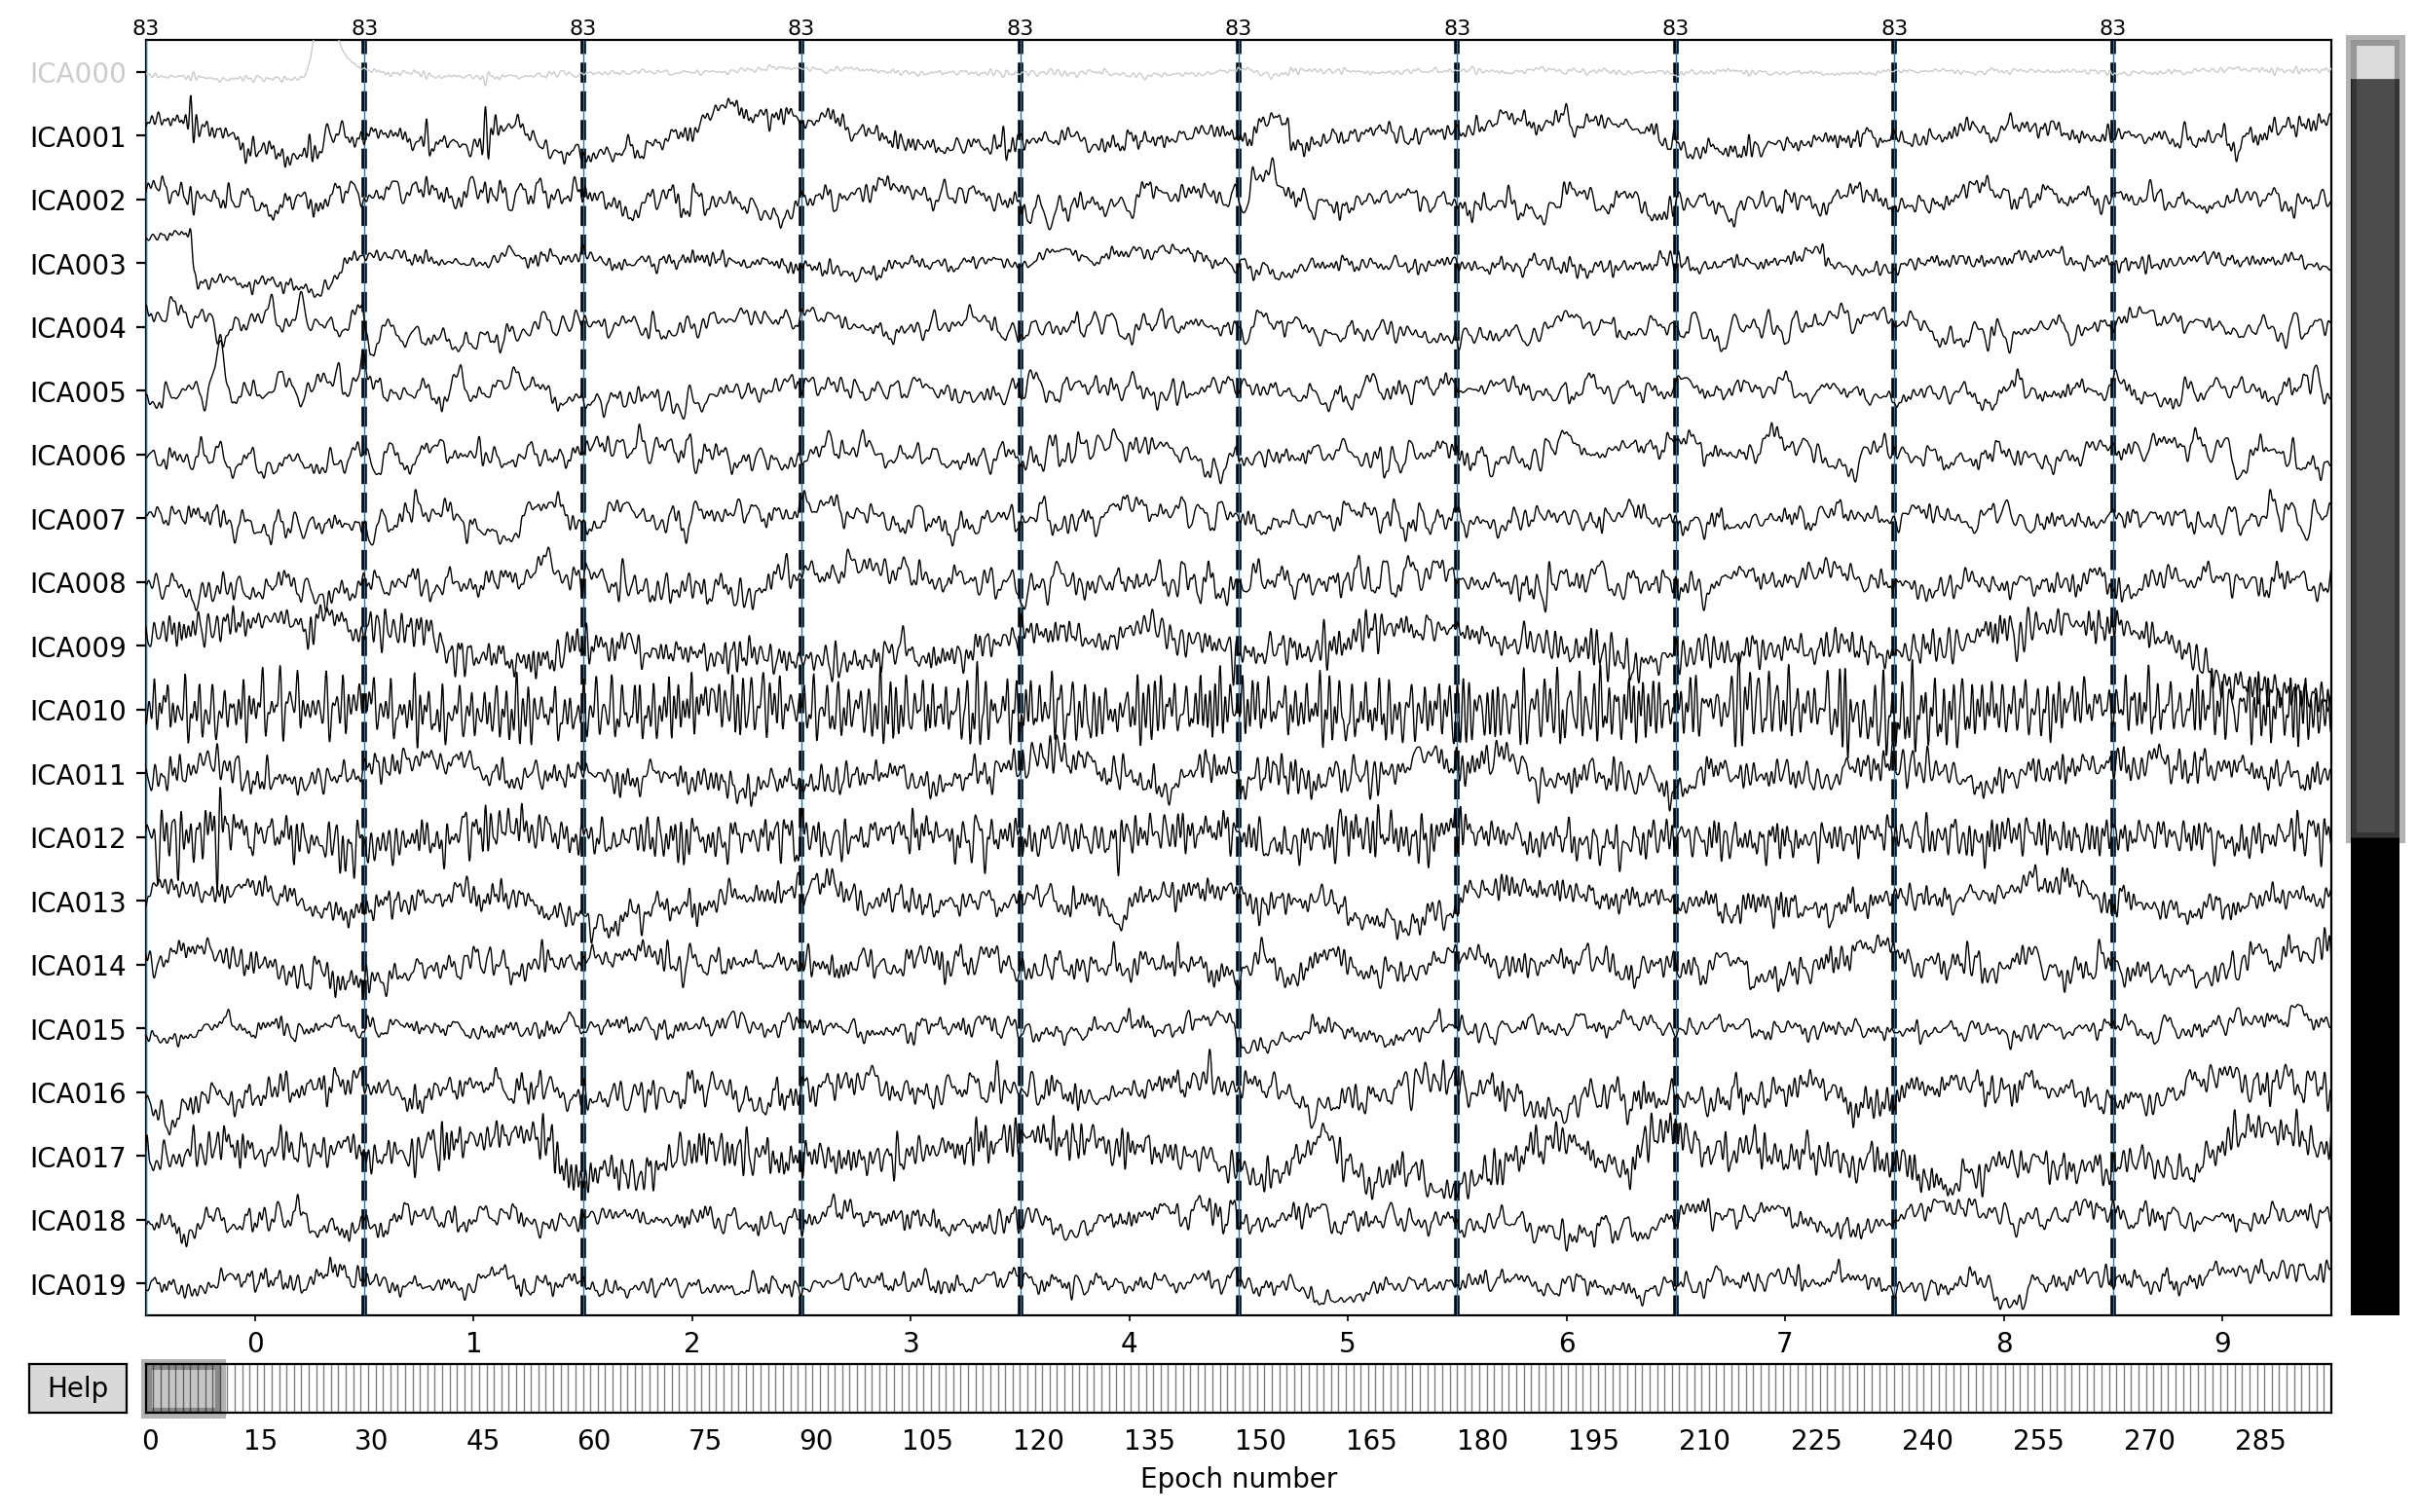

In [21]:
ica.plot_sources(epochs_faster[['83']], start=0, stop=10)

Not setting metadata
Not setting metadata
1519 matching events found


<ipython-input-44-3cb9b4b784ce>:5: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs_faster[subset], start=0, stop=10)


No baseline correction applied
0 projection items activated
0 bad epochs dropped


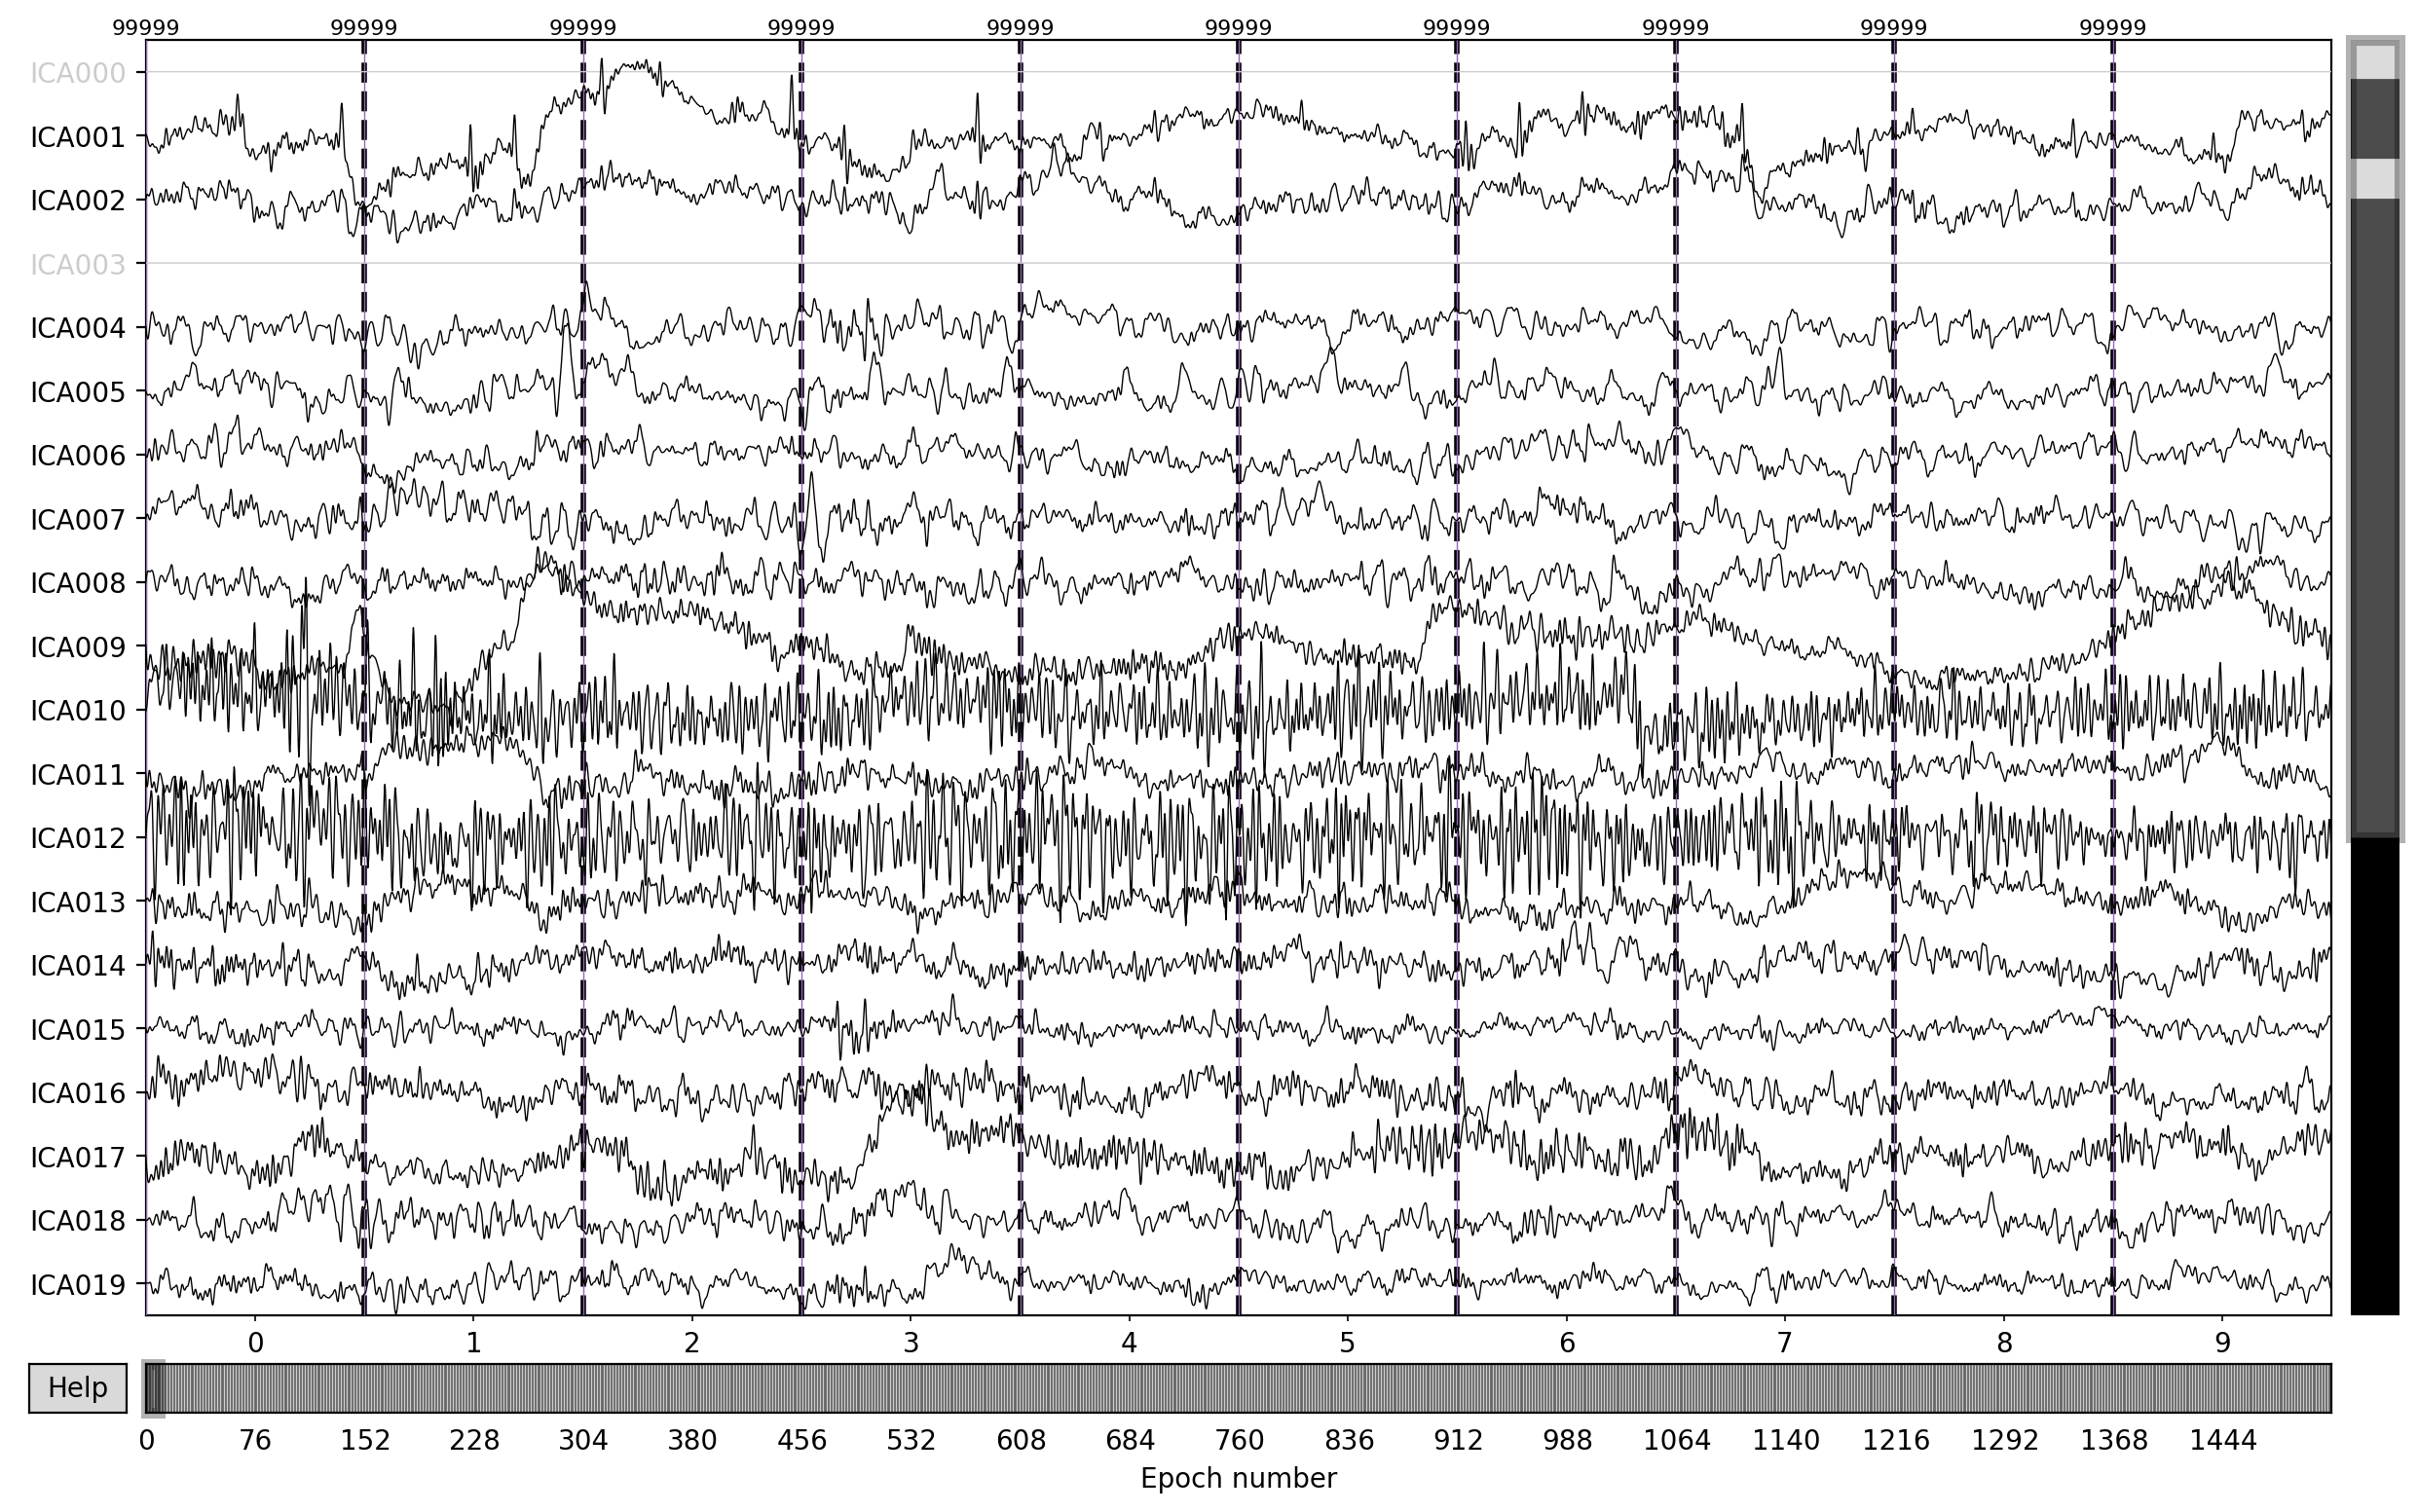

In [44]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 5th event)
subset = list(epochs.event_id.keys())[::5]
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster[subset], start=0, stop=10)

In [22]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
# Optional

# If you found a component that should have been excluded but it wasn't you can exclude it here:
ica.plot_sources(epochs_faster[subset], start=0, stop=10)

In [ ]:
# Optional

# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.4. Save cleaned epochs (recommended)

In [35]:

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)


# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, raw.info['condition'], 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 2.1. Run autoreject

In [23]:
reject_log = run_autoreject(epochs_faster, n_jobs=11, subset=True)

Fitting autoreject on random (n=2155) subset of epochs: 
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 64/64 [02:55<00:00,  2.75s/it]


Repairing epochs:   0%|          | 0/2155 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 21/2155 [00:00<00:10, 203.71it/s]

Repairing epochs:   2%|▏         | 42/2155 [00:00<00:10, 193.92it/s]

Repairing epochs:   3%|▎         | 62/2155 [00:00<00:11, 180.84it/s]

Repairing epochs:   4%|▍         | 81/2155 [00:00<00:11, 172.89it/s]

Repairing epochs:   5%|▍         | 99/2155 [00:00<00:12, 168.60it/s]

Repairing epochs:   5%|▌         | 116/2155 [00:00<00:12, 161.29it/s]

Repairing epochs:   6%|▌         | 133/2155 [00:00<00:13, 146.74it/s]

Repairing epochs:   7%|▋         | 148/2155 [00:00<00:15, 131.90it/s]

Repairing epochs:   8%|▊         | 162/2155 [00:01<00:15, 132.54it/s]

Repairing epochs:   8%|▊         | 181/2155 [00:01<00:13, 147.68it/s]

Repairing epochs:   9%|▉         | 197/2155 [00:01<00:14, 135.96it/s]

Repairing epochs:  10%|▉         | 213/2155 [00:01<00:13, 140.49it/s]

Repairing epochs:

Repairing epochs:   5%|▌         | 110/2155 [00:01<00:25, 81.37it/s]

Repairing epochs:   6%|▌         | 119/2155 [00:01<00:24, 82.68it/s]

Repairing epochs:   6%|▌         | 128/2155 [00:01<00:24, 81.24it/s]

Repairing epochs:   6%|▋         | 140/2155 [00:01<00:22, 90.28it/s]

Repairing epochs:   7%|▋         | 150/2155 [00:01<00:22, 88.43it/s]

Repairing epochs:   7%|▋         | 159/2155 [00:01<00:23, 86.43it/s]

Repairing epochs:   8%|▊         | 168/2155 [00:02<00:23, 84.88it/s]

Repairing epochs:   8%|▊         | 177/2155 [00:02<00:24, 81.81it/s]

Repairing epochs:   9%|▊         | 186/2155 [00:02<00:24, 80.61it/s]

Repairing epochs:   9%|▉         | 195/2155 [00:02<00:26, 75.11it/s]

Repairing epochs:   9%|▉         | 203/2155 [00:02<00:27, 72.18it/s]

Repairing epochs:  10%|▉         | 211/2155 [00:02<00:26, 72.79it/s]

Repairing epochs:  10%|█         | 221/2155 [00:02<00:24, 79.43it/s]

Repairing epochs:  11%|█         | 230/2155 [00:02<00:24, 77.87it/s]

Repairing epochs:  1

Repairing epochs:  50%|████▉     | 1067/2155 [00:13<00:15, 71.60it/s]

Repairing epochs:  50%|████▉     | 1075/2155 [00:13<00:17, 62.02it/s]

Repairing epochs:  50%|█████     | 1082/2155 [00:13<00:16, 63.87it/s]

Repairing epochs:  51%|█████     | 1091/2155 [00:13<00:15, 69.17it/s]

Repairing epochs:  51%|█████     | 1099/2155 [00:14<00:15, 69.70it/s]

Repairing epochs:  52%|█████▏    | 1112/2155 [00:14<00:12, 84.70it/s]

Repairing epochs:  52%|█████▏    | 1121/2155 [00:14<00:12, 82.57it/s]

Repairing epochs:  52%|█████▏    | 1130/2155 [00:14<00:13, 74.14it/s]

Repairing epochs:  53%|█████▎    | 1138/2155 [00:14<00:15, 65.99it/s]

Repairing epochs:  53%|█████▎    | 1148/2155 [00:14<00:13, 73.30it/s]

Repairing epochs:  54%|█████▎    | 1157/2155 [00:14<00:13, 76.75it/s]

Repairing epochs:  54%|█████▍    | 1165/2155 [00:14<00:13, 74.93it/s]

Repairing epochs:  55%|█████▍    | 1175/2155 [00:15<00:12, 81.09it/s]

Repairing epochs:  55%|█████▍    | 1185/2155 [00:15<00:11, 84.80it/s]

Repair

Repairing epochs:  95%|█████████▍| 2044/2155 [00:25<00:01, 86.95it/s]

Repairing epochs:  95%|█████████▌| 2053/2155 [00:25<00:01, 86.72it/s]

Repairing epochs:  96%|█████████▌| 2062/2155 [00:26<00:01, 87.01it/s]

Repairing epochs:  96%|█████████▌| 2072/2155 [00:26<00:00, 89.56it/s]

Repairing epochs:  97%|█████████▋| 2082/2155 [00:26<00:00, 84.92it/s]

Repairing epochs:  97%|█████████▋| 2091/2155 [00:26<00:00, 78.12it/s]

Repairing epochs:  97%|█████████▋| 2099/2155 [00:26<00:00, 77.12it/s]

Repairing epochs:  98%|█████████▊| 2107/2155 [00:26<00:00, 76.03it/s]

Repairing epochs:  98%|█████████▊| 2115/2155 [00:26<00:00, 74.22it/s]

Repairing epochs:  99%|█████████▊| 2125/2155 [00:26<00:00, 78.96it/s]

Repairing epochs:  99%|█████████▉| 2134/2155 [00:26<00:00, 80.74it/s]

Repairing epochs:  99%|█████████▉| 2143/2155 [00:27<00:00, 74.75it/s]

Repairing epochs: 100%|██████████| 2155/2155 [00:27<00:00, 78.95it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 

Repairing epochs:  35%|███▍      | 746/2155 [00:09<00:17, 78.59it/s]

Repairing epochs:  35%|███▍      | 754/2155 [00:09<00:18, 77.05it/s]

Repairing epochs:  35%|███▌      | 762/2155 [00:09<00:18, 74.06it/s]

Repairing epochs:  36%|███▌      | 770/2155 [00:09<00:18, 73.25it/s]

Repairing epochs:  36%|███▌      | 780/2155 [00:10<00:17, 77.68it/s]

Repairing epochs:  37%|███▋      | 791/2155 [00:10<00:15, 85.62it/s]

Repairing epochs:  37%|███▋      | 801/2155 [00:10<00:15, 88.32it/s]

Repairing epochs:  38%|███▊      | 810/2155 [00:10<00:15, 84.56it/s]

Repairing epochs:  38%|███▊      | 819/2155 [00:10<00:16, 82.68it/s]

Repairing epochs:  38%|███▊      | 829/2155 [00:10<00:15, 85.05it/s]

Repairing epochs:  39%|███▉      | 838/2155 [00:10<00:15, 82.56it/s]

Repairing epochs:  39%|███▉      | 847/2155 [00:10<00:15, 82.23it/s]

Repairing epochs:  40%|███▉      | 856/2155 [00:10<00:15, 82.94it/s]

Repairing epochs:  40%|████      | 865/2155 [00:11<00:16, 79.97it/s]

Repairing epochs:  4

Repairing epochs:  77%|███████▋  | 1670/2155 [00:21<00:08, 58.63it/s]

Repairing epochs:  78%|███████▊  | 1677/2155 [00:22<00:08, 54.42it/s]

Repairing epochs:  78%|███████▊  | 1684/2155 [00:22<00:08, 56.52it/s]

Repairing epochs:  78%|███████▊  | 1690/2155 [00:22<00:08, 55.91it/s]

Repairing epochs:  79%|███████▊  | 1696/2155 [00:22<00:08, 55.31it/s]

Repairing epochs:  79%|███████▉  | 1705/2155 [00:22<00:07, 63.98it/s]

Repairing epochs:  79%|███████▉  | 1713/2155 [00:22<00:06, 67.32it/s]

Repairing epochs:  80%|███████▉  | 1722/2155 [00:22<00:05, 73.45it/s]

Repairing epochs:  80%|████████  | 1731/2155 [00:22<00:05, 77.09it/s]

Repairing epochs:  81%|████████  | 1740/2155 [00:22<00:05, 79.84it/s]

Repairing epochs:  81%|████████▏ | 1751/2155 [00:23<00:04, 86.07it/s]

Repairing epochs:  82%|████████▏ | 1761/2155 [00:23<00:04, 89.26it/s]

Repairing epochs:  82%|████████▏ | 1771/2155 [00:23<00:04, 90.08it/s]

Repairing epochs:  83%|████████▎ | 1781/2155 [00:23<00:04, 92.00it/s]

Repair

Repairing epochs:   9%|▉         | 189/2155 [00:02<00:28, 69.39it/s]

Repairing epochs:   9%|▉         | 197/2155 [00:02<00:33, 57.60it/s]

Repairing epochs:   9%|▉         | 204/2155 [00:02<00:32, 60.33it/s]

Repairing epochs:  10%|▉         | 213/2155 [00:02<00:29, 66.14it/s]

Repairing epochs:  10%|█         | 225/2155 [00:02<00:24, 77.49it/s]

Repairing epochs:  11%|█         | 234/2155 [00:03<00:24, 77.77it/s]

Repairing epochs:  11%|█▏        | 245/2155 [00:03<00:22, 85.19it/s]

Repairing epochs:  12%|█▏        | 254/2155 [00:03<00:22, 83.29it/s]

Repairing epochs:  12%|█▏        | 263/2155 [00:03<00:23, 79.60it/s]

Repairing epochs:  13%|█▎        | 272/2155 [00:03<00:22, 82.34it/s]

Repairing epochs:  13%|█▎        | 281/2155 [00:03<00:22, 83.02it/s]

Repairing epochs:  14%|█▎        | 292/2155 [00:03<00:20, 88.81it/s]

Repairing epochs:  14%|█▍        | 301/2155 [00:03<00:21, 86.85it/s]

Repairing epochs:  14%|█▍        | 310/2155 [00:03<00:22, 82.31it/s]

Repairing epochs:  1

Repairing epochs:  53%|█████▎    | 1142/2155 [00:14<00:12, 82.54it/s]

Repairing epochs:  53%|█████▎    | 1151/2155 [00:14<00:12, 83.46it/s]

Repairing epochs:  54%|█████▍    | 1160/2155 [00:15<00:13, 76.35it/s]

Repairing epochs:  54%|█████▍    | 1168/2155 [00:15<00:12, 76.03it/s]

Repairing epochs:  55%|█████▍    | 1178/2155 [00:15<00:12, 81.25it/s]

Repairing epochs:  55%|█████▌    | 1187/2155 [00:15<00:12, 80.24it/s]

Repairing epochs:  55%|█████▌    | 1196/2155 [00:15<00:12, 78.09it/s]

Repairing epochs:  56%|█████▌    | 1204/2155 [00:15<00:12, 76.91it/s]

Repairing epochs:  56%|█████▋    | 1214/2155 [00:15<00:11, 82.33it/s]

Repairing epochs:  57%|█████▋    | 1223/2155 [00:15<00:11, 80.88it/s]

Repairing epochs:  57%|█████▋    | 1232/2155 [00:15<00:12, 72.69it/s]

Repairing epochs:  58%|█████▊    | 1242/2155 [00:16<00:11, 78.17it/s]

Repairing epochs:  58%|█████▊    | 1251/2155 [00:16<00:11, 81.29it/s]

Repairing epochs:  58%|█████▊    | 1260/2155 [00:16<00:11, 80.47it/s]

Repair

Repairing epochs:  95%|█████████▌| 2050/2155 [00:27<00:01, 76.17it/s]

Repairing epochs:  96%|█████████▌| 2059/2155 [00:27<00:01, 78.64it/s]

Repairing epochs:  96%|█████████▌| 2071/2155 [00:27<00:00, 86.86it/s]

Repairing epochs:  97%|█████████▋| 2080/2155 [00:27<00:00, 83.75it/s]

Repairing epochs:  97%|█████████▋| 2089/2155 [00:27<00:00, 74.51it/s]

Repairing epochs:  97%|█████████▋| 2097/2155 [00:27<00:00, 71.90it/s]

Repairing epochs:  98%|█████████▊| 2105/2155 [00:27<00:00, 71.53it/s]

Repairing epochs:  98%|█████████▊| 2115/2155 [00:28<00:00, 75.89it/s]

Repairing epochs:  99%|█████████▊| 2124/2155 [00:28<00:00, 77.31it/s]

Repairing epochs:  99%|█████████▉| 2133/2155 [00:28<00:00, 79.89it/s]

Repairing epochs:  99%|█████████▉| 2142/2155 [00:28<00:00, 72.41it/s]

Repairing epochs: 100%|██████████| 2155/2155 [00:28<00:00, 75.54it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:07<01:03,  7.08s/it]


Fold:  20%|██        | 2/10 [00:12<00:50,  6





Estimated consensus=0.60 and n_interpolate=32


In [24]:
# Drop bad epochs (stage 1)

epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

Dropped 983 epochs: 0, 1, 2, 3, 6, 7, 9, 10, 11, 20, 32, 42, 45, 61, 64, 68, 112, 162, 187, 207, 230, 233, 247, 250, 251, 252, 263, 267, 284, 285, 288, 315, 319, 321, 322, 323, 331, 332, 333, 336, 337, 338, 342, 347, 349, 350, 351, 352, 353, 354, 355, 356, 357, 360, 361, 368, 370, 372, 373, 374, 375, 376, 384, 385, 517, 538, 553, 560, 561, 642, 643, 644, 660, 661, 662, 663, 666, 667, 668, 745, 746, 948, 955, 956, 959, 960, 962, 963, 966, 1115, 1116, 1223, 1225, 1228, 1237, 1243, 1244, 1250, 1252, 1253, 1254, 1259, 1260, 1261, 1339, 1357, 1358, 1485, 1486, 1503, 1504, 1515, 1519, 1536, 1537, 1538, 1539, 1540, 1541, 1543, 1544, 1545, 1546, 1548, 1572, 1573, 1736, 1737, 1738, 1825, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1840, 1842, 1843, 1845, 1846, 1847, 1848, 1858, 1861, 1863, 1864, 1865, 1870, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1909, 1910, 1911, 1912, 1918, 1920, 1921, 1922, 1923, 1924, 1925, 2045, 2046, 2063, 2185, 2205, 2206, 2207, 2208, 2209, 2211, 2212, 2214, 2215, 

In [ ]:
# Drop bad epochs (stage 2) - after visual inspection
idx = np.where(np.count_nonzero(reject_log.labels, axis=1) > epochs_faster.info['nchan']/2)[0].tolist()

# # Plot just the bad epochs!
if idx: 
    epochs_faster[idx].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                n_channels=32)
    
epochs_autoreject.drop(idx, reason='AUTOREJECT')

In [ ]:
epochs_autoreject.drop(idx, reason='AUTOREJECT')

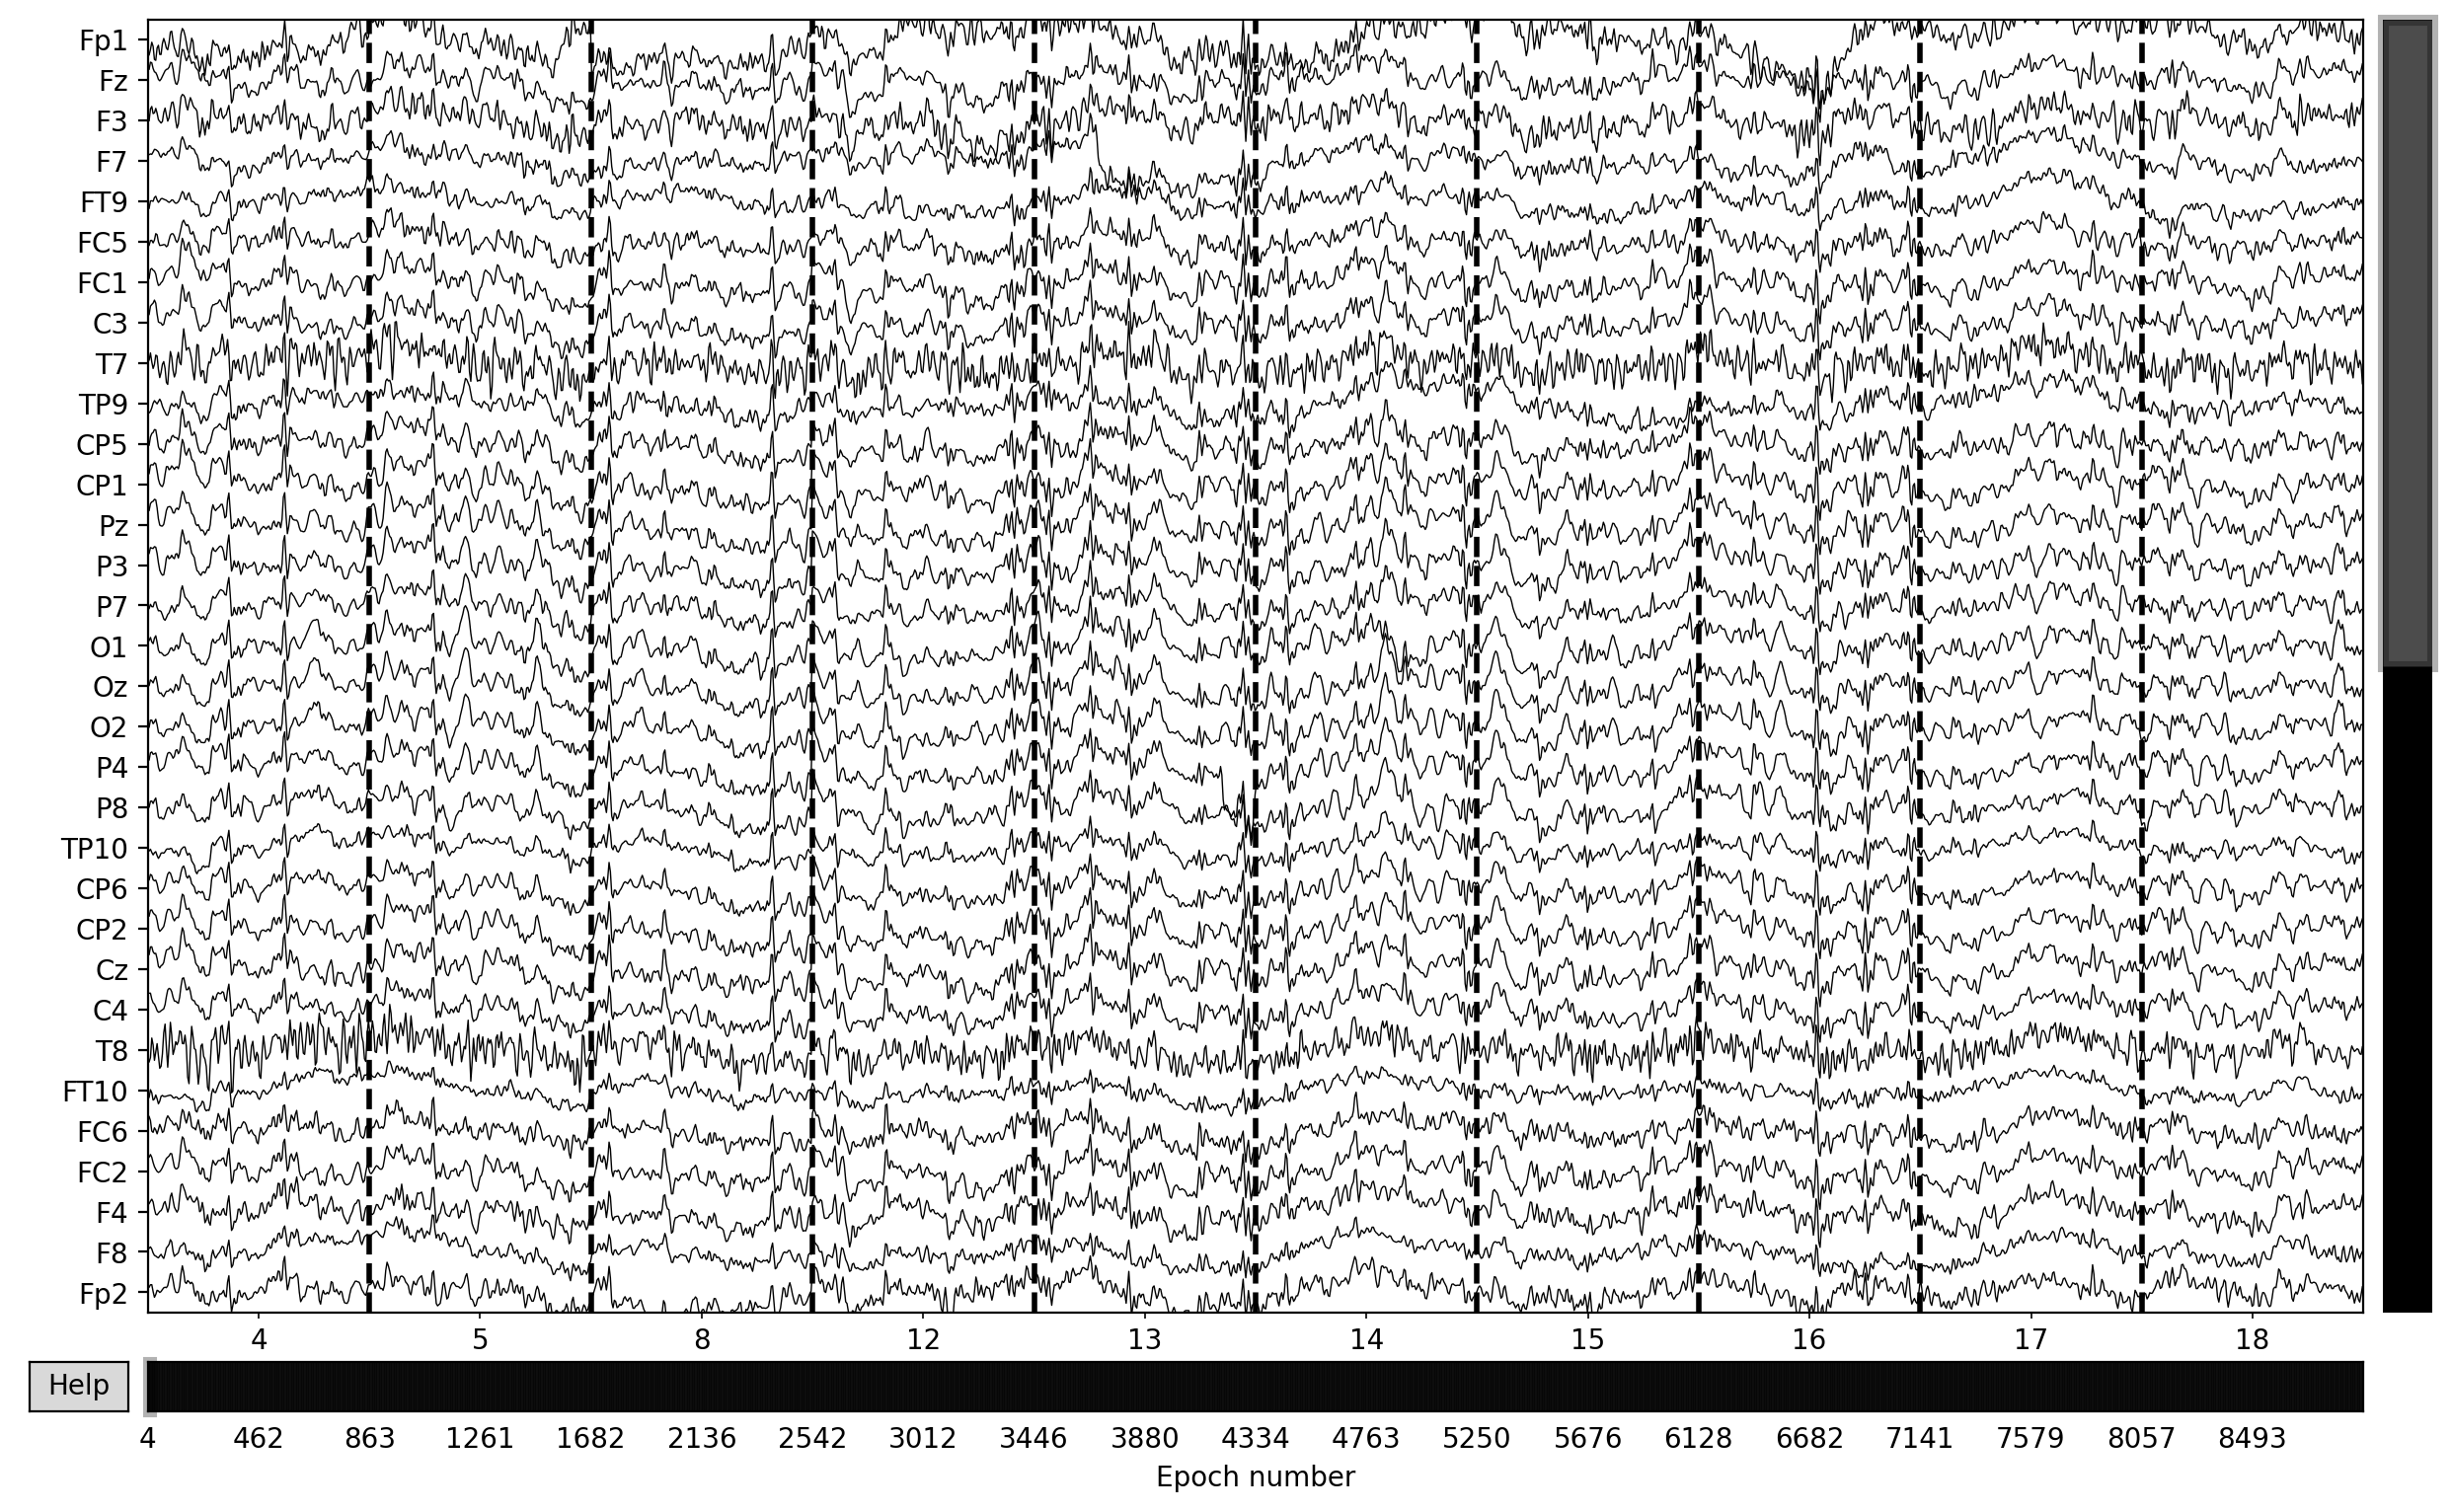

Not setting metadata
Not setting metadata
7639 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dropped 0 epochs: 
Channels marked as bad: none


In [28]:
epochs_autoreject.plot(n_channels=32, n_epochs=10)

In [ ]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 3. Run ransac

In [29]:
epochs_ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:  1.8min remaining:  8.0min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed:  1.8min remaining:  3.2min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed:  2.0min remaining:   45.9s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:  2.4min finished


[Done]
Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


In [30]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

<Info | 14 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 description: n_components: 2, interpolated: T7
 dig: 64 items (64 EEG)
 fid: 82_L_Day2
 highpass: 0.5 Hz
 is_annotated: True
 lowpass: 45.0 Hz
 meas_date: 2021-05-11 14:06:18 UTC
 nchan: 64
 num_day: 2
 projs: []
 sfreq: 500.0 Hz
 subject: 82
>

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

In [ ]:
epochs_ransac

In [ ]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# if there are additional channels marked for interpolation, we can interpolate them here.

if epochs_ransac.info['bads']:
    bads_str = ', '.join(epochs_ransac.info['bads'])
    epochs_ransac.interpolate_bads()
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)

### 5. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.

In [31]:
epochs_ransac.set_eeg_reference('average')

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Epochs |  7639 events (all good), 0 - 0.998 sec, baseline off, ~1.82 GB, data loaded,
 '100': 37
 '106': 1
 '110': 178
 '112': 168
 '113': 696
 '114': 67
 '115': 242
 '116': 282
 '117': 171
 '118': 58
 '119': 165
 '120': 178
 '122': 167
 '123': 687
 '124': 66
 '125': 244
 '126': 295
 '127': 174
 '128': 56
 '129': 146
 '132': 3
 '133': 20
 '134': 4
 '135': 4
 '136': 3
 '137': 3
 '138': 1
 '139': 4
 '140': 491
 '141': 510
 '142': 498
 '143': 478
 '144': 15
 '145': 27
 '146': 13
 '147': 59
 '148': 37
 '149': 5
 '151': 93
 '152': 23
 '161': 71
 '162': 65
 '163': 67
 '164': 68
 '165': 67
 '201': 0
 '202': 0
 '203': 0
 '204': 1
 '205': 0
 '211': 4
 '213': 0
 '214': 36
 '215': 2
 '230': 3
 '5': 0
 '83': 273
 '84': 11
 '85': 8
 '87': 264
 '89': 0
 '91': 8
 '92': 20
 '93': 17
 '94': 42
 '95': 9
 '96': 64
 '97': 15
 '98': 45
 '99': 11
 '99999': 99>

### 6. Annotate continuous data


In [32]:
start_times = [epochs.events[idx][0] / raw.info['sfreq'] 
               for idx, value in enumerate(epochs_ransac.drop_log) if value]

duration = (epochs_ransac.events[1][0] - epochs_ransac.events[0][0]) / raw.info['sfreq'] 

raw.annotations.append(onset=start_times,
                       duration=[duration] * len(start_times),
                       description='BAD_auto')

<Annotations | 7930 segments: BAD_auto (1308), New Segment/ (6), ...>

In [36]:
# Create path to annotated files
annotated_raw_path = os.path.join(interim_path, raw.info['condition'], 'raw')
if not os.path.exists(annotated_raw_path):
    os.makedirs(annotated_raw_path)

# Save annotated continuous data
fid = raw.info["fid"]
raw_annotated_fname = f'{fid}_bad_annotated'
postfix = '-raw.fif.gz'
raw.save(os.path.join(annotated_raw_path, f'{raw_annotated_fname}{postfix}'), overwrite=True)

Writing /Volumes/crnl-memo-hd/EEG 2/preprocessed/L/raw/82_L_Day2_bad_annotated-raw.fif.gz
Closing /Volumes/crnl-memo-hd/EEG 2/preprocessed/L/raw/82_L_Day2_bad_annotated-raw.fif.gz
[done]


### 7. Save cleaned epochs

#### 7.1. Resting period before ASRT

In [ ]:
# Create path to annotated files
epochs_rs_path = os.path.join(interim_path, raw.info['condition'], 'epochs_rs')
if not os.path.exists(epochs_rs_path):
    os.makedirs(epochs_rs_path)

rs_period_name = f'rs_{raw.info["num_day"]}_1'
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_{rs_period_name}'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_ransac[rs_period_name].save(os.path.join(epochs_rs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### 7.2. Resting period before ASRT

In [ ]:
rs_period_name = f'rs_{raw.info["num_day"]}_2'
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_{rs_period_name}'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_ransac[rs_period_name].save(os.path.join(epochs_rs_path,
                                                f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### 7.3. ASRT

In [ ]:
# Create path to annotated files
epochs_asrt_path = os.path.join(interim_path, raw.info['condition'], 'epochs_asrt')
if not os.path.exists(epochs_asrt_path):
    os.makedirs(epochs_asrt_path)

In [ ]:
for sequence, periods in events.groupby('sequence')['event'].apply(set).to_dict().items():
    #epochs_to_merge = [epochs_ransac[period] for period in periods]
    #merged_epochs = mne.concatenate_epochs(epochs_to_merge, offset=True)
    fid = f'{raw.info["subject"]}_{raw.info["condition"]}_asrt_{raw.info["num_day"]}_{sequence}'
    epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
    postfix = '-epo.fif.gz'
    
    epochs_ransac[sorted(set(periods))].save(os.path.join(epochs_asrt_path,
                                                          f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_ransac

In [ ]:
# cleanup from memory
del raw, epochs, epochs_autoreject, epochs_ransac

plt.close('all')